In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Generation du dataset
n = 1000

education_levels = ['Sans diplome', 'Brevet', 'Bac', 'BTS/DUT', 'Licence', 'Master', 'Doctorat']
occupations = ['Administratif', 'Commercial', 'Technique', 'Cadre', 'Direction', 'Artisan', 'Ouvrier']
sectors = ['Public', 'Prive', 'Independant']
marital_status = ['Celibataire', 'Marie(e)', 'Divorce(e)', 'Veuf(ve)']
regions = ['Ile-de-France', 'PACA', 'Auvergne-Rhone-Alpes', 'Nouvelle-Aquitaine', 'Autres']

df = pd.DataFrame({
    'age': np.random.randint(18, 70, n),
    'education': np.random.choice(education_levels, n, p=[0.05, 0.10, 0.20, 0.20, 0.20, 0.20, 0.05]),
    'occupation': np.random.choice(occupations, n),
    'secteur': np.random.choice(sectors, n, p=[0.25, 0.60, 0.15]),
    'heures_semaine': np.random.randint(20, 60, n),
    'experience': np.random.randint(0, 45, n),
    'situation_familiale': np.random.choice(marital_status, n, p=[0.30, 0.50, 0.15, 0.05]),
    'nb_enfants': np.random.choice([0, 1, 2, 3, 4], n, p=[0.25, 0.25, 0.30, 0.15, 0.05]),
    'region': np.random.choice(regions, n, p=[0.25, 0.15, 0.15, 0.10, 0.35]),
    'teletravail': np.random.choice(['Jamais', 'Partiel', 'Complet'], n, p=[0.50, 0.35, 0.15]),
    'anciennete_poste': np.random.randint(0, 30, n),
    'satisfaction': np.random.uniform(1, 10, n).round(1)
})

# Variable cible basee sur des criteres realistes
education_score = df['education'].map({
    'Sans diplome': 0, 'Brevet': 1, 'Bac': 2, 'BTS/DUT': 3,
    'Licence': 4, 'Master': 5, 'Doctorat': 6
})

occupation_score = df['occupation'].map({
    'Ouvrier': 0, 'Artisan': 1, 'Administratif': 2, 'Technique': 3,
    'Commercial': 4, 'Cadre': 5, 'Direction': 6
})

salaire_score = (
    df['age'] * 0.02 +
    education_score * 0.8 +
    occupation_score * 0.6 +
    df['experience'] * 0.05 +
    df['heures_semaine'] * 0.03 +
    (df['secteur'] == 'Prive').astype(int) * 0.5 +
    (df['region'] == 'Ile-de-France').astype(int) * 0.8 +
    np.random.normal(0, 1, n)
)

df['salaire_50k'] = (salaire_score > np.percentile(salaire_score, 75)).astype(int)

# Valeurs manquantes
missing_cols = {
    'experience': 40,
    'heures_semaine': 25,
    'satisfaction': 50,
    'teletravail': 30,
    'nb_enfants': 20
}

for col, n_missing in missing_cols.items():
    df.loc[np.random.choice(n, n_missing, replace=False), col] = np.nan

### Tache 1.1 : Exploration initiale

1. Quelles sont les dimensions du dataset ?
2. Quels sont les types de chaque colonne ?
3. Combien de valeurs manquantes par colonne ?
4. Quelle est la distribution de la variable cible ?

In [2]:
# 1. Dimensions du dataset
print(f"Dimensions du dataset : {df.shape}")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

Dimensions du dataset : (1000, 13)
Nombre de lignes : 1000
Nombre de colonnes : 13


In [3]:
print(df.dtypes)

age                      int32
education                  str
occupation                 str
secteur                    str
heures_semaine         float64
experience             float64
situation_familiale        str
nb_enfants             float64
region                     str
teletravail                str
anciennete_poste         int32
satisfaction           float64
salaire_50k              int64
dtype: object


In [4]:
def analyse_missing_data(df):
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)

    missing_table = pd.DataFrame({
        "Colonnes": missing.index,
        "Valeurs manquantes": missing.values,
        "Pourcentage": missing_pct.values
    })

    missing_table = missing_table[missing_table["Valeurs manquantes"] > 0].sort_values("Pourcentage", ascending=False)

    return missing_table

missing_data = analyse_missing_data(df)
missing_data

,Colonnes,Valeurs manquantes,Pourcentage
11,satisfaction,50,5.0
5,experience,40,4.0
9,teletravail,30,3.0
4,heures_semaine,25,2.5
7,nb_enfants,20,2.0


In [5]:
print(df['salaire_50k'].value_counts())
print("\nPourcentage :")
print(df['salaire_50k'].value_counts(normalize=True) * 100)

salaire_50k
0    750
1    250
Name: count, dtype: int64

Pourcentage :
salaire_50k
0    75.0
1    25.0
Name: proportion, dtype: float64


### Tache 1.2 : Identifier les types de variables

Classifiez les variables en :

- **Numeriques** : variables continues ou discretes
- **Categorielles nominales** : sans ordre naturel
- **Categorielles ordinales** : avec un ordre logique

In [11]:
numeric_features = ['age', 'heures_semaine', 'experience', 'nb_enfants', 'anciennete_poste', 'satisfaction']
ordinal_features = ['education', 'teletravail']
nominal_features = ['occupation', 'secteur', 'situation_familiale', 'region']

### Tache 1.3 : Visualisations exploratoires

Creez des visualisations pertinentes :

1. Distribution de l'age selon le salaire (>50k ou non)
2. Relation entre education et salaire
3. Heatmap des correlations numeriques

<Figure size 1000x600 with 0 Axes>

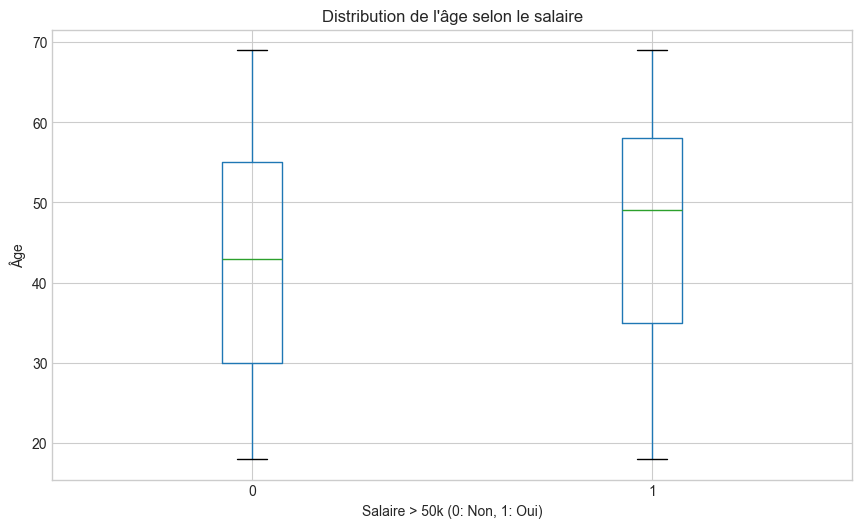

In [8]:
plt.figure(figsize=(10, 6))
df.boxplot(column='age', by='salaire_50k', figsize=(10, 6))
plt.title('Distribution de l\'âge selon le salaire')
plt.suptitle('')
plt.xlabel('Salaire > 50k (0: Non, 1: Oui)')
plt.ylabel('Âge')
plt.show()

<Figure size 1200x600 with 0 Axes>

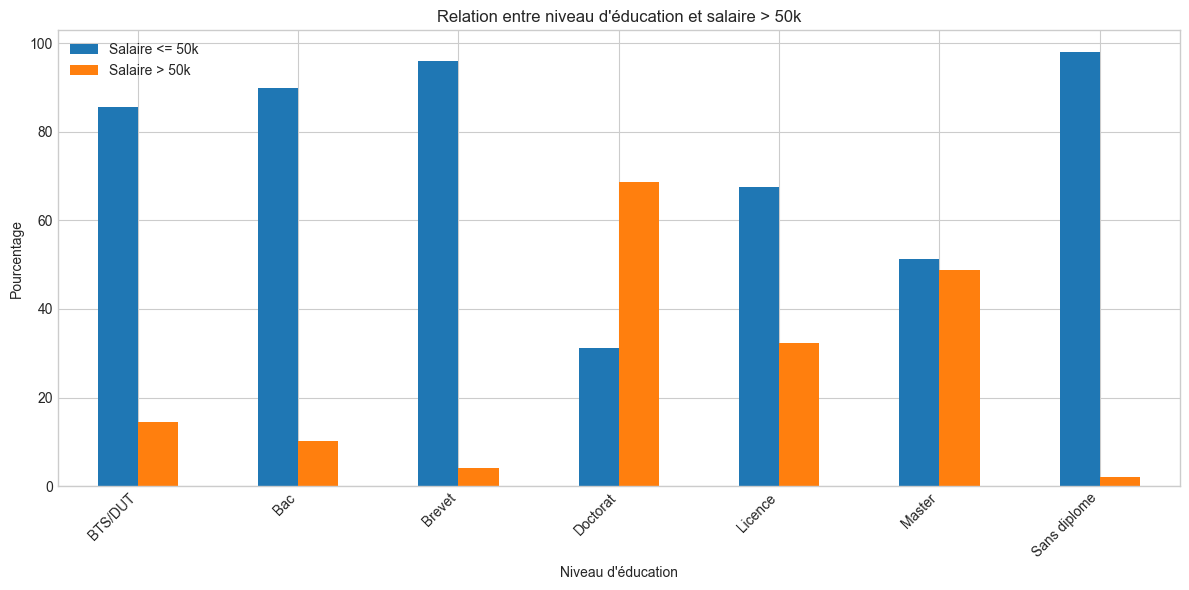

In [9]:
plt.figure(figsize=(12, 6))
education_salary = pd.crosstab(df['education'], df['salaire_50k'], normalize='index') * 100
education_salary.plot(kind='bar', figsize=(12, 6))
plt.title('Relation entre niveau d\'éducation et salaire > 50k')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Pourcentage')
plt.legend(['Salaire <= 50k', 'Salaire > 50k'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

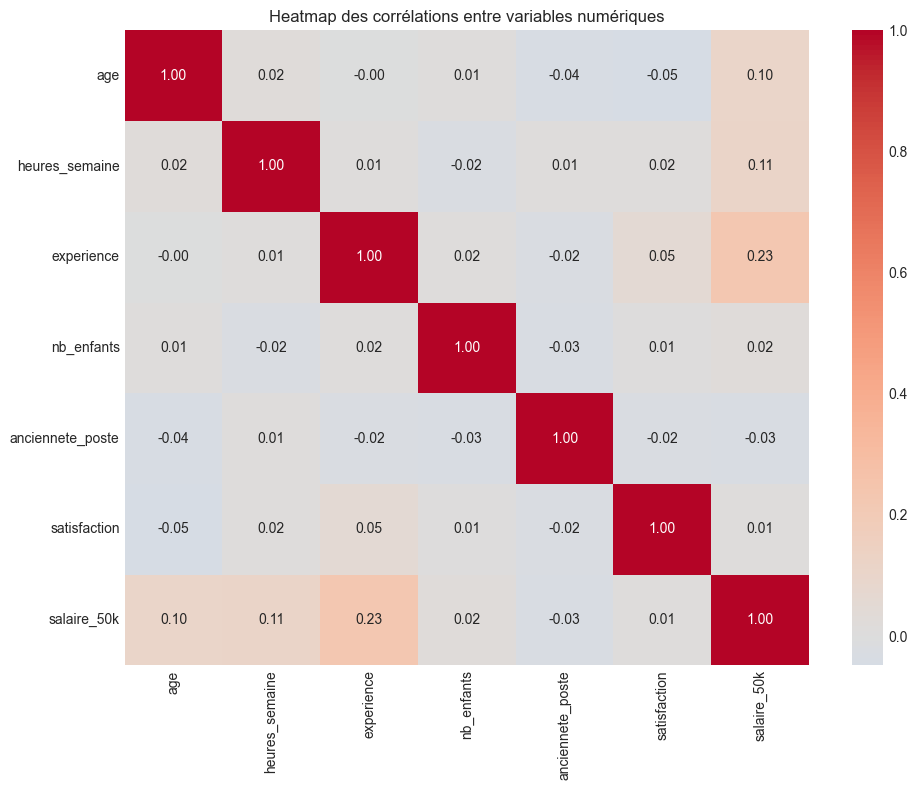

In [12]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_features + ['salaire_50k']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Heatmap des corrélations entre variables numériques')
plt.tight_layout()
plt.show()


## Partie 2 : Preparation des donnees

### Tache 2.1 : Separation Train/Test

Separez les donnees en :

- Features (X) et target (y)
- Train (80%) et Test (20%)
- Utilisez `stratify=y` pour conserver la distribution de la cible

In [13]:
X = df.drop('salaire_50k', axis=1)
y = df['salaire_50k']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

## Partie 3 : Construction du Pipeline

### Tache 3.1 : Pipeline pour variables numeriques

Creez un pipeline qui :

1. Impute les valeurs manquantes avec la mediane
2. Standardise les donnees

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


### Tache 3.2 : Pipeline pour variables nominales

Creez un pipeline qui :

1. Impute les valeurs manquantes avec le mode
2. Applique One-Hot Encoding

In [15]:
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


### Tache 3.3 : Pipeline pour variables ordinales

Creez un pipeline qui :

1. Impute les valeurs manquantes avec le mode
2. Applique Ordinal Encoding avec l'ordre correct

**Ordres a respecter :**

- `education` : Sans diplome < Brevet < Bac < BTS/DUT < Licence < Master < Doctorat
- `teletravail` : Jamais < Partiel < Complet

In [16]:
education_order = ['Sans diplome', 'Brevet', 'Bac', 'BTS/DUT', 'Licence', 'Master', 'Doctorat']
teletravail_order = ['Jamais', 'Partiel', 'Complet']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[education_order, teletravail_order], handle_unknown='use_encoded_value', unknown_value=-1))
])


### Tache 3.4 : ColumnTransformer

Combinez les trois transformateurs dans un `ColumnTransformer`.

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ]
)

### Tache 3.5 : Pipeline complet avec modele

Creez le pipeline final avec :

1. Le preprocessor
2. Un classificateur (LogisticRegression)

In [18]:
pipeline_complet = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

### Tache 4.1 : Entrainement

Entrainez le pipeline sur les donnees d'entrainement.

In [19]:
pipeline_complet.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('nom', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

### Tache 4.2 : Evaluation sur le test

1. Calculez l'accuracy sur le test

In [20]:
y_pred = pipeline_complet.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.86


In [21]:
train_accuracy = pipeline_complet.score(X_train, y_train)
print(f"Accuracy sur le train : {train_accuracy:.4f}")
print(f"Accuracy sur le test : {accuracy:.4f}")

Accuracy sur le train : 0.8825
Accuracy sur le test : 0.8600


## Partie 5 : Sauvegarde et utilisation

### Tache 5.1 : Sauvegarder le pipeline

### Tache 5.2 : Faire une prediction sur de nouvelles donnees

Creez un nouvel individu et predisez s'il gagne plus de 50K

In [22]:
import joblib

joblib.dump(pipeline_complet, 'pipeline_salaire.pkl')

['pipeline_salaire.pkl']

In [24]:
new_person = pd.DataFrame({
    'age': [30],
    'education': ['Master'],
    'occupation': ["Cadre"],
    'secteur': ['Prive'],
    'heures_semaine': [35],
    'experience': [5],
    'situation_familiale': ["Celibataire"],
    'nb_enfants': [2],
    'region': ["PACA"],
    'teletravail': ["Partiel"],
    'anciennete_poste': [3],
    'satisfaction': [6]
})

prediction = pipeline_complet.predict(new_person)

print(f"Prédiction : {'Salaire > 50K' if prediction == 1 else 'Salaire <= 50K'}")

Prédiction : Salaire > 50K
